

Epoch 1/10

81/81 [==============================] - 10s 55ms/step - loss: 0.0113
Epoch 2/10
81/81 [==============================] - 4s 53ms/step - loss: 0.0019
Epoch 3/10
81/81 [==============================] - 4s 53ms/step - loss: 0.0017
Epoch 4/10
81/81 [==============================] - 4s 55ms/step - loss: 0.0016
Epoch 5/10
81/81 [==============================] - 4s 54ms/step - loss: 0.0014
Epoch 6/10
81/81 [==============================] - 5s 59ms/step - loss: 0.0013
Epoch 7/10
81/81 [==============================] - 4s 46ms/step - loss: 0.0013
Epoch 8/10
81/81 [==============================] - 4s 50ms/step - loss: 0.0012
Epoch 9/10
81/81 [==============================] - 4s 54ms/step - loss: 0.0010
Epoch 10/10
19/19 [==============================] - 1s 26ms/step
Métricas del modelo LSTM en el conjunto de prueba:
MSE: 18356.86
MAE: 102.72
RMSE: 135.49
R²: 0.99


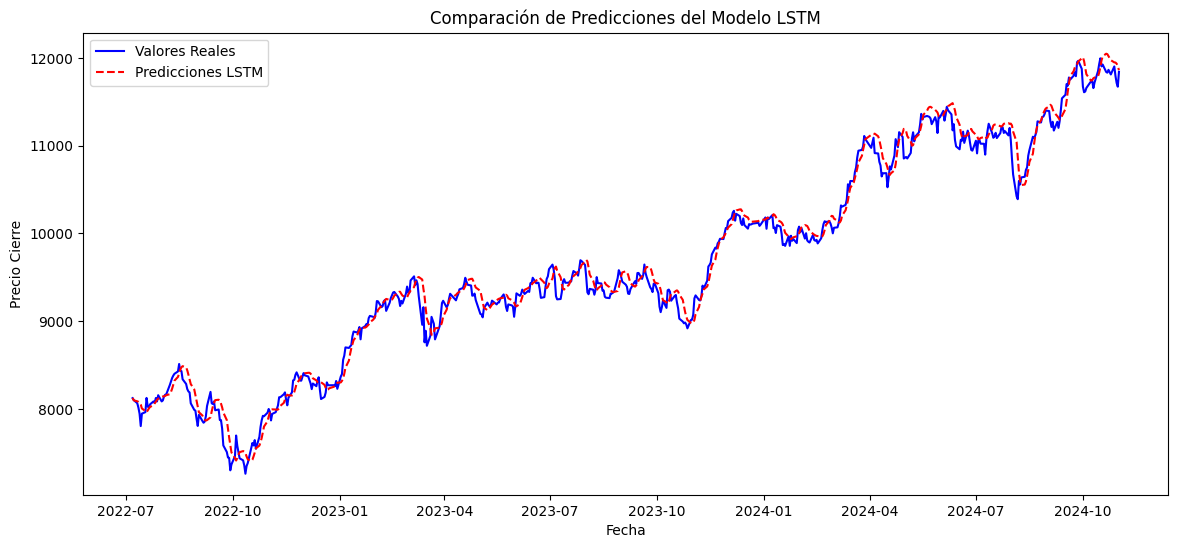

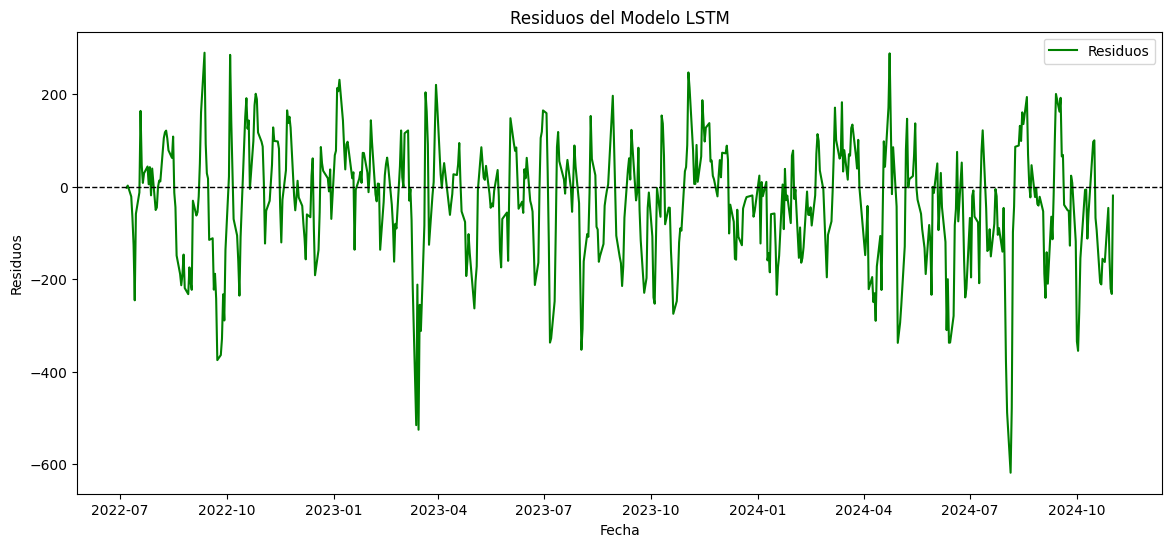

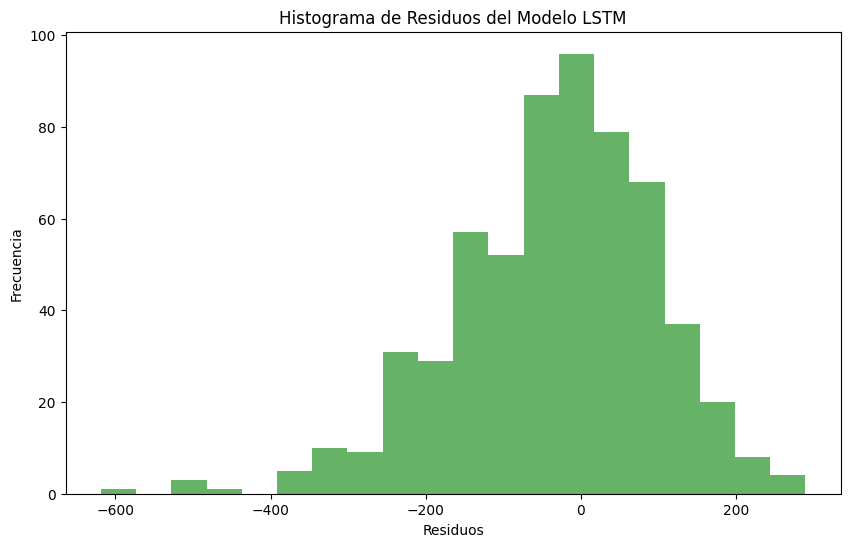

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Cargar los datos (reemplazar 'data.csv' con tu archivo de datos)
df = pd.read_csv('ibex_clean.csv', index_col='Date', parse_dates=True)
df = df[['Close']]  # Seleccionar solo la columna 'Close'

# Dividir los datos en entrenamiento (80%) y prueba (20%)
train_size = int(len(df) * 0.8)
train = df.iloc[:train_size]
test = df.iloc[train_size:]

# Escalar los datos entre 0 y 1
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Función para crear una estructura de datos de características y etiquetas
def create_dataset(dataset, time_step=1):
    X, y = [], []
    for i in range(len(dataset) - time_step):
        X.append(dataset[i:(i + time_step), 0])
        y.append(dataset[i + time_step, 0])
    return np.array(X), np.array(y)

# Crear datos de entrenamiento y prueba con un paso de tiempo de 60
time_step = 60
X_train, y_train = create_dataset(train_scaled, time_step)
X_test, y_test = create_dataset(test_scaled, time_step)

# Cambiar la forma de los datos a [samples, time steps, features]
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# Construir el modelo LSTM
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Entrenar el modelo
model.fit(X_train, y_train, epochs=10, batch_size=32, verbose=1)

# Realizar predicciones
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Desescalar las predicciones
train_predictions = scaler.inverse_transform(train_predictions)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions)
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calcular métricas de rendimiento para el conjunto de prueba
mse = mean_squared_error(y_test, test_predictions)
mae = mean_absolute_error(y_test, test_predictions)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, test_predictions)

print(f'Métricas del modelo LSTM en el conjunto de prueba:')
print(f'MSE: {mse:.2f}')
print(f'MAE: {mae:.2f}')
print(f'RMSE: {rmse:.2f}')
print(f'R²: {r2:.2f}')

# Graficar las predicciones vs los valores reales
plt.figure(figsize=(14, 6))
plt.plot(test.index[time_step:], y_test, label='Valores Reales', color='blue')
plt.plot(test.index[time_step:], test_predictions, label='Predicciones LSTM', color='red', linestyle='--')
plt.xlabel('Fecha')
plt.ylabel('Precio Cierre')
plt.title('Comparación de Predicciones del Modelo LSTM')
plt.legend()
plt.show()

# Graficar los residuos
residuals = y_test - test_predictions
plt.figure(figsize=(14, 6))
plt.plot(test.index[time_step:], residuals, label='Residuos', color='green')
plt.axhline(0, color='black', linestyle='--', linewidth=1)
plt.xlabel('Fecha')
plt.ylabel('Residuos')
plt.title('Residuos del Modelo LSTM')
plt.legend()
plt.show()

# Graficar histograma de los residuos
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=20, color='green', alpha=0.6)
plt.xlabel('Residuos')
plt.ylabel('Frecuencia')
plt.title('Histograma de Residuos del Modelo LSTM')
plt.show()


1/1 [==============================] - 0s 43ms/step


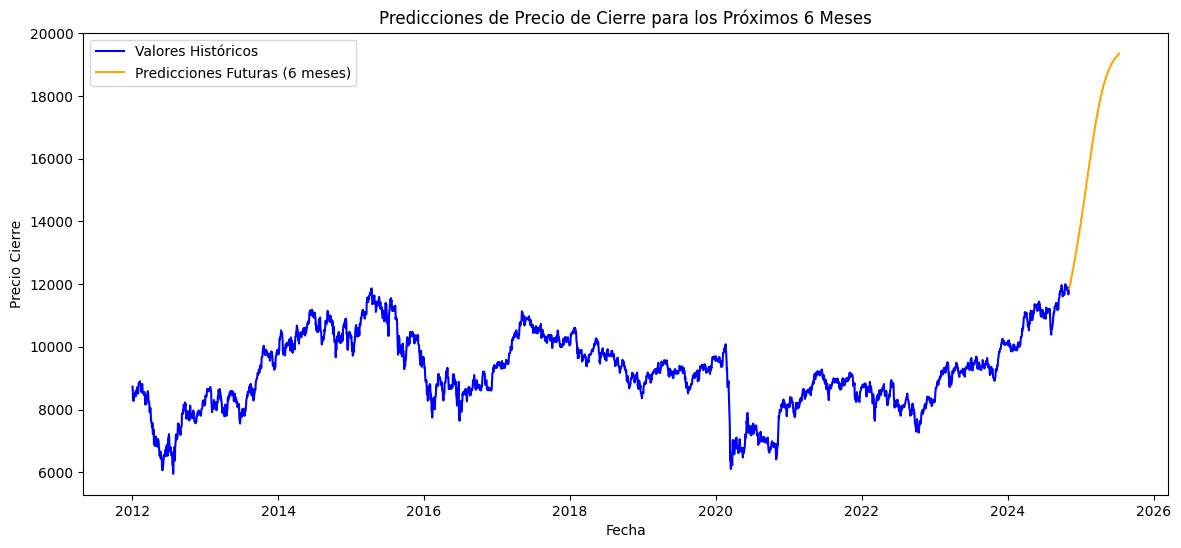

In [3]:
# Crear un conjunto de datos para predecir los próximos 6 meses (180 días)
future_days = 180
last_data = test_scaled[-time_step:]  # Tomar los últimos datos del conjunto de prueba

future_predictions = []

for _ in range(future_days):
    # Realizar predicciones con los últimos datos conocidos
    pred_input = last_data.reshape(1, time_step, 1)
    pred = model.predict(pred_input)
    
    # Añadir la predicción al array de predicciones futuras
    future_predictions.append(pred[0, 0])
    
    # Actualizar los datos para incluir la nueva predicción
    last_data = np.append(last_data[1:], pred)

# Desescalar las predicciones futuras
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Crear un índice de fechas para las predicciones futuras
future_dates = pd.date_range(start=test.index[-1], periods=future_days + 1, freq='B')[1:]

# Graficar las predicciones de los próximos 6 meses
plt.figure(figsize=(14, 6))
plt.plot(df.index, df['Close'], label='Valores Históricos', color='blue')
plt.plot(future_dates, future_predictions, label='Predicciones Futuras (6 meses)', color='orange')
plt.xlabel('Fecha')
plt.ylabel('Precio Cierre')
plt.title('Predicciones de Precio de Cierre para los Próximos 6 Meses')
plt.legend()
plt.show()
